In [18]:
import numpy as np
from collections import deque, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
#from lightgbm import plot_importance
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler


In [5]:
df = pd.read_csv('../msr_traindata.txt', sep=',')
df.head()

,readOrwrite,address,avg_freq,avg_reuse,std_freq,std_reuse,warm,hit_ratio
0,0,383496192,0.0,0.0,0.000000,0.0,1,0.0
1,0,2822144,0.0,0.0,0.031235,0.0,1,0.0
2,0,-1073700864,0.0,0.0,0.044151,0.0,1,0.0
3,0,3354624,0.0,0.0,0.054047,0.0,1,0.0
4,0,2961408,0.0,0.0,0.062378,0.0,1,0.0


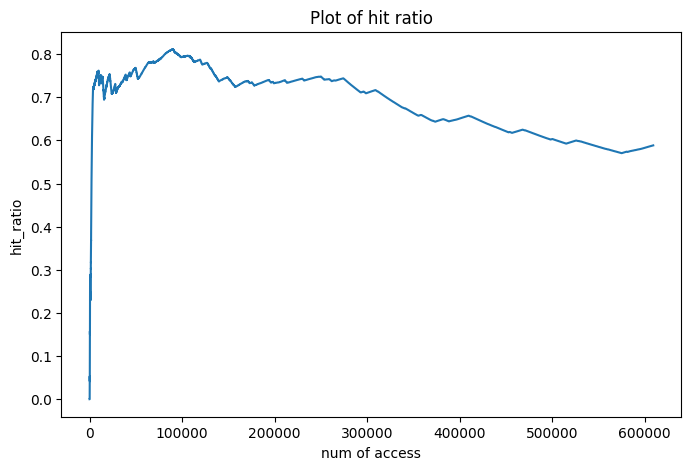

In [6]:
plt.figure(figsize=(8,5))
plt.plot(df['hit_ratio'])
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('Plot of hit ratio')
plt.show()

In [7]:
#cache warmming 일때의 상황 제외
df = df.loc[df['warm']!=1]
df.drop(['warm'], axis=1, inplace=True)
df.head()

,readOrwrite,address,avg_freq,avg_reuse,std_freq,std_reuse,hit_ratio
1797,0,439373824,1.75,156.02,1.180686,269.197053,0.430478
1798,0,397709312,1.76,156.08,1.182128,269.196637,0.430795
1799,0,396718080,1.76,156.03,1.185217,269.212928,0.431111
1800,0,396546048,1.76,156.00,1.188296,269.222782,0.431427
1801,0,396611584,1.76,155.99,1.192187,269.226917,0.431743


In [8]:
#feature 증폭
df['pre_avg_freq'] = df['avg_freq'].shift(periods=1)
df['pre_avg_reuse'] = df['avg_reuse'].shift(periods=1)
df['pre_std_freq'] = df['std_freq'].shift(periods=1)
df['pre_std_reuse'] = df['std_reuse'].shift(periods=1)
df

,readOrwrite,address,avg_freq,avg_reuse,std_freq,std_reuse,hit_ratio,pre_avg_freq,pre_avg_reuse,pre_std_freq,pre_std_reuse
1797,0,439373824,1.75,156.02,1.180686,269.197053,0.430478,NaN,NaN,NaN,NaN
1798,0,397709312,1.76,156.08,1.182128,269.196637,0.430795,1.75,156.02,1.180686,269.197053
1799,0,396718080,1.76,156.03,1.185217,269.212928,0.431111,1.76,156.08,1.182128,269.196637
1800,0,396546048,1.76,156.00,1.188296,269.222782,0.431427,1.76,156.03,1.185217,269.212928
1801,0,396611584,1.76,155.99,1.192187,269.226917,0.431743,1.76,156.00,1.188296,269.222782
...,...,...,...,...,...,...,...,...,...,...,...
609306,0,782336,350.90,27585.10,629.431482,64058.647884,0.588355,350.90,27585.34,629.429728,64058.543875
609307,0,476356608,350.90,27584.70,629.433127,64058.816352,0.588356,350.90,27585.10,629.431482,64058.647884
609308,0,395972608,350.90,27584.57,629.434164,64058.871386,0.588357,350.90,27584.70,629.433127,64058.816352
609309,0,476364800,350.90,27584.37,629.435497,64058.960078,0.588357,350.90,27584.57,629.434164,64058.871386


In [19]:
#정규화
scaler = MinMaxScaler()
df[:] = scaler.fit_transform(df[:])

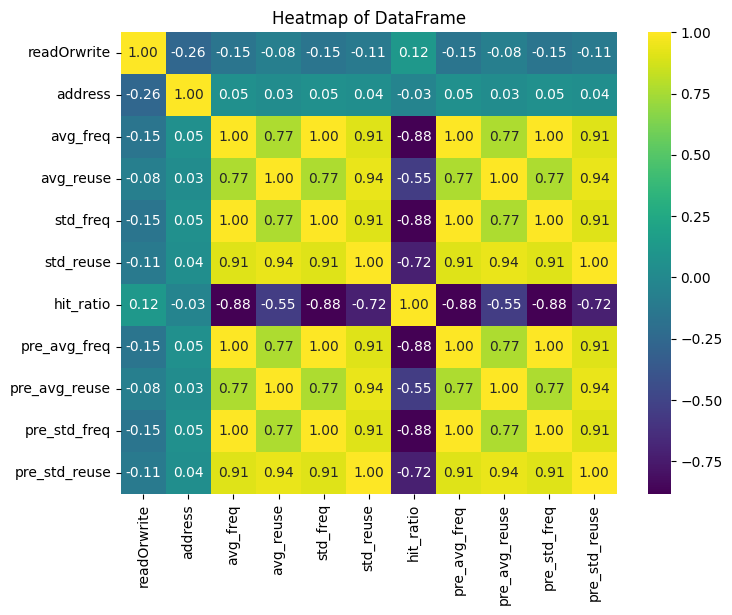

In [11]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap of DataFrame')
plt.show()  # Add this line to explicitly display the plot

In [12]:
#필요없는 데이터 삭제
df.drop(['address'], axis=1, inplace=True)

#결측치 제거
df =df.dropna()

([<matplotlib.axis.XTick at 0x7ff7b178b910>,
 [Text(1, 0, 'readOrwrite'),
  Text(2, 0, 'avg_freq'),
  Text(3, 0, 'avg_reuse'),
  Text(4, 0, 'std_freq'),
  Text(5, 0, 'std_reuse'),
  Text(6, 0, 'hit_ratio'),
  Text(7, 0, 'pre_avg_freq'),
  Text(8, 0, 'pre_avg_reuse'),
  Text(9, 0, 'pre_std_freq'),
  Text(10, 0, 'pre_std_reuse')])

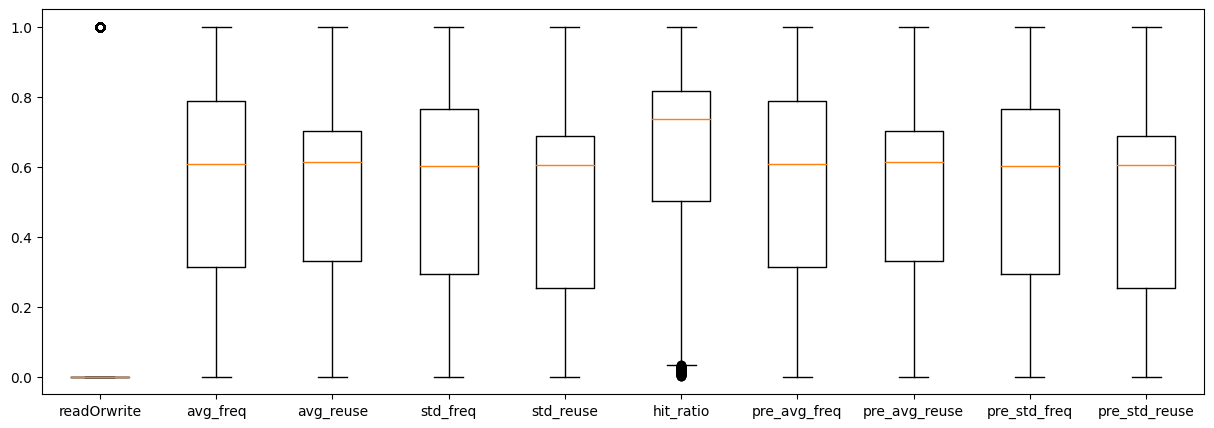

In [22]:
#box plot으로 이상치 확인
plt.figure(figsize=(15,5))
plt.boxplot(df)

x_labels= list(df.columns)
plt.xticks(range(1,11), x_labels)

In [21]:

y = df['hit_ratio']
x = df.drop(['hit_ratio'], axis=1)

X_train, X_test = train_test_split(x, test_size=0.2, shuffle=False, random_state=123)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False,random_state=123)


In [204]:
#LogisticRegression

def lgbm():

    #파라미터는 dict에
    param = {'num_leaves': 31, 'objective': 'regression', 'metric':'mse'}
    #train data를 별도의 Dataset객체로 만들어야 함
    train_data = lgb.Dataset(X_train, label=y_train.values)
    #boosting을 몇 번 할건지 결정
    num_round = 10 

    bst = lgb.train(param, train_data, num_round)

    y_pred = bst.predict(X_test)

    print(y_pred)


def LR():
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    plt.figure(figsize=(5, 3))
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.xlabel('num of access')
    plt.ylabel('hit_ratio')
    plt.title('LR')
    plt.show()


In [239]:
#파라미터는 dict에
from lightgbm import LGBMClassifier

bayesian_params = {
    'max_depth':(6, 16), #트리 최대 깊이
    'num_leaves':(24,64), #트리 하나에 최대 잎 개수
    'min_child_samples': (10, 200), #하나의 잎에 최소 데이터 개수 (오버피팅 대응)
    'min_child_weight': (1, 50), #하나의 잎에 최소 sum hessian
    'subsample': (0.5, 1), #
    'colsample_bytree': (0.5, 1), #피처의 50% 를 트레이닝 전에 선택
    'max_bin': (10, 500), #bins 의 최대 개수
    'reg_lambda': (0.001, 10), #L2 regularization
    'reg_alpha': (0.01, 50) #L1 regularization 
    }

def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
  params  = {
      "n_estimators" : 500, 
      "learning_rate": 0.003,
      'max_depth': int(round(max_depth)),
      'num_leaves': int(round(num_leaves)),
      'min_child_samples': int(round(min_child_samples)),
      'min_child_weight': int(round(min_child_weight)),
      'subsample': max(min(subsample, 1), 0), # 0 과 1 사이
      'colsample_bytree': max(min(colsample_bytree, 1), 0),
      'max_bin':  max(int(round(max_bin)),10),
      'reg_lambda': max(reg_lambda,0),
      'reg_alpha': max(reg_alpha, 0)

  }

  lgb_model = LGBMClassifier(**params)
  lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'ase', verbose= 100, 
                early_stopping_rounds= 100)
  valid_proba = lgb_model.predict_proba(valid_x)[:, 1]
  roc_auc = roc_auc_score(valid_y, valid_proba)

  return roc_auc


#lgbBO = BayesianOptimization(f= lgb_roc_eval, pbounds=bayesian_params, random_state = 0)
#lgbBO.maximize(init_points = 5, n_iter = 25)




|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


TypeError: fit() got an unexpected keyword argument 'verbose'

In [ ]:
#iteration 수행 결과
#lgbBO.res

In [ ]:
#최대 결과를 내는 index와 그떄의 parameter조합 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

In [4]:
param  = {
    "n_estimators" : 500, 
    "learning_rate": 0.5,
    "metric" : 'mse',
    "objective" : 'regression'
}

In [2]:
#train data를 별도의 Dataset객체로 만들어야 함
train_data = lgb.Dataset(X_train, label=y_train.values)
#boosting을 몇 번 할건지 결정
num_round = 10 

bst = lgb.train(param, train_data, num_round)
#lgb.LGBMRegressor
y_pred = bst.predict(X_test)


NameError: name 'lgb' is not defined

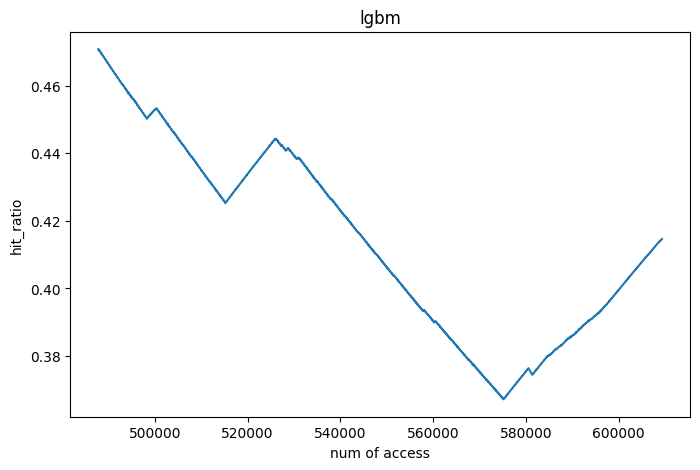

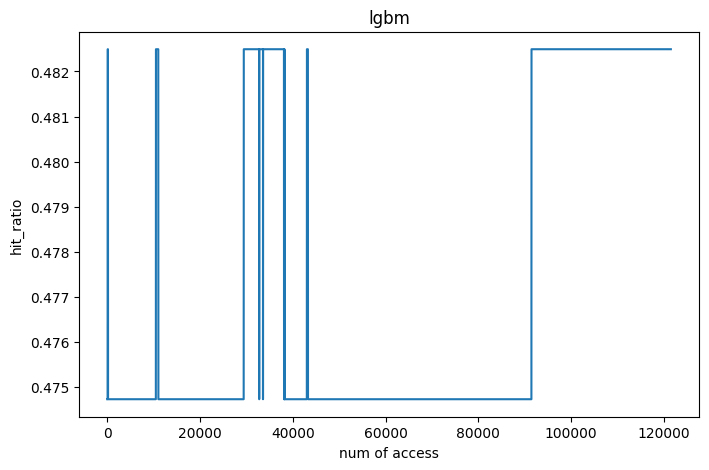

In [54]:
y_pred_df = pd.DataFrame(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lgbm')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(y_pred)
plt.xlabel('num of access')
plt.ylabel('hit_ratio')
plt.title('lgbm')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

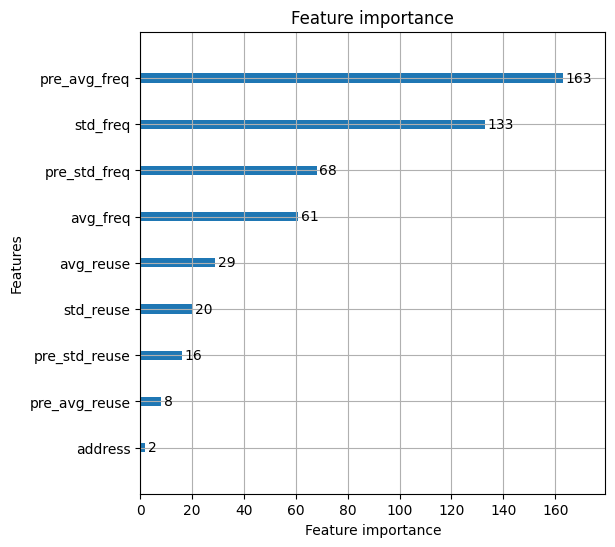

In [207]:
f, ax = plt.subplots(figsize=(6,6))
plot_importance(bst,ax=ax)